In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
# print(os.listdir("../input"))
# base_dir = "../input/aptos2019-blindness-detection/"

In [2]:
import seaborn as sns

In [3]:
transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split,random_state=42)
    trainset = Subset(dataset, train_idx)
    testset = Subset(dataset, val_idx)
    return trainset,testset

# dataset = datasets.ImageFolder('dataset_dr/', transform=transform)
# print(len(dataset))
# trainset,testset = train_val_dataset(dataset)
# print(len(trainset))
# print(len(testset))

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
# testoader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=4096 , out_features=5)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [71]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [72]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

class ConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts, k, s, p):
        super(ConvBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts, kernel_size=(k, k), stride=(s, s), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.convolution(input_img)

        return x


class ReduceConvBlock(nn.Module):
    def __init__(self, in_fts, out_fts_1, out_fts_2, k, p):
        super(ReduceConvBlock, self).__init__()
        self.redConv = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts_1, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_fts_1, out_channels=out_fts_2, kernel_size=(k, k), stride=(1, 1), padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, input_img):
        x = self.redConv(input_img)

        return x


class AuxClassifier(nn.Module):
    def __init__(self, in_fts, num_classes):
        super(AuxClassifier, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(5, 5), stride=(3, 3))
        self.conv = nn.Conv2d(in_channels=in_fts, out_channels=128, kernel_size=(1, 1), stride=(1, 1))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(4 * 4 * 128, 1024)
        self.dropout = nn.Dropout(p=0.7)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.avgpool(input_img)
        x = self.conv(x)
        x = self.relu(x)
        x = x.reshape(N, -1)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.classifier(x)

        return x


class InceptionModule(nn.Module):
    def __init__(self, curr_in_fts, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool_proj):
        super(InceptionModule, self).__init__()
        self.conv1 = ConvBlock(curr_in_fts, f_1x1, 1, 1, 0)
        self.conv2 = ReduceConvBlock(curr_in_fts, f_3x3_r, f_3x3, 3, 1)
        self.conv3 = ReduceConvBlock(curr_in_fts, f_5x5_r, f_5x5, 5, 2)

        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=curr_in_fts, out_channels=f_pool_proj, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )

    def forward(self, input_img):
        out1 = self.conv1(input_img)
        out2 = self.conv2(input_img)
        out3 = self.conv3(input_img)
        out4 = self.pool_proj(input_img)

        x = torch.cat([out1, out2, out3, out4], dim=1)

        return x


class MyGoogleNet(nn.Module):
    def __init__(self, in_fts=3, num_class=5):
        super(MyGoogleNet, self).__init__()
        self.conv1 = ConvBlock(in_fts, 64, 7, 2, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, 1, 1, 0),
            ConvBlock(64, 192, 3, 1, 1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.aux_classifier1 = AuxClassifier(512, num_class)
        self.aux_classifier2 = AuxClassifier(528, num_class)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1024 * 7 * 7, num_class)
        )

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.conv1(input_img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool1(x)
        x = self.inception_4a(x)
        out1 = self.aux_classifier1(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        out2 = self.aux_classifier2(x)
        x = self.inception_4e(x)
        x = self.maxpool1(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.avgpool(x)
        x = x.reshape(N, -1)
        x = self.classifier(x)
        if self.training == True:
            return x
        else:
            return x

In [ ]:
from torchvision.transforms.transforms import RandomVerticalFlip
'''Train CIFAR10 with PyTorch.'''
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import os
import argparse

print("starting dl project")

lr = 0.011254067205095794
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
best_acc_test=0
batch_size = 64
total_epochs = 150
optimizer_fn="adagrad"
data_dir ="/scratch/pn2158/dataset_dr/"
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []




# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# Model
print('==> Building model..')

#net = AlexNet() #to compile the model
net = MyGoogleNet()
#net = ResNet50(5,3)

if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)

    
net.to(device=device) #to send the model for training on either cuda or cpu




criterion = nn.CrossEntropyLoss()

if optimizer_fn == 'sgd':
  optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
if optimizer_fn == 'nesterov':
  optimizer = optim.SGD(net.parameters(), lr=lr, nesterov = True,momentum=0.9, weight_decay = 5e-4)
if optimizer_fn == 'adam':
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)	
if optimizer_fn == 'adagrad':
  optimizer = optim.Adagrad(net.parameters(), lr=lr,weight_decay=5e-4)
if optimizer_fn == 'adadelta':
  optimizer = optim.Adadelta(net.parameters(), lr=lr,weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

dataset = datasets.ImageFolder(data_dir, transform=transform)
print(len(dataset))
trainset,testset = train_val_dataset(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
# Training
def train(epoch):
    global best_acc 
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    data_time = 0
    train_time = 0
    total_time = 0

    
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        start=time.monotonic() 
        inputs, targets = inputs.to(device), targets.to(device)
        end = time.monotonic()

        data_time += (end - start)



        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    if acc > best_acc:
          best_acc = acc




    print("Training accuracy in this epoch is: "+ str(acc))
    train_accuracy_history.append(acc)
    
    finalLoss = train_loss/len(trainloader)
    #print("Best epoch accuracy is "+ str(best_acc))
    print("Final loss is "+ str(finalLoss))
    train_loss_history.append(finalLoss)
    
    


def test(epoch):
    global best_acc_test
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc_test:
        torch.save(net.state_dict(),"GoogleNet.pt")
        best_acc_test = acc
    finalLoss = test_loss/len(testloader)
    test_loss_history.append(finalLoss)
    test_accuracy_history.append(acc)
    
    print("test acc is  "+ str(acc))
    

for epoch in range(150):
    train(epoch)
    test(epoch)
    scheduler.step()

starting dl project
==> Preparing data..
==> Building model..
3662

Epoch: 0
Training accuracy in this epoch is: 54.011608057357456
Final loss is 1.1517690135085064
test acc is  68.62210095497953

Epoch: 1
Training accuracy in this epoch is: 67.53158074428133
Final loss is 0.9026750753755155
test acc is  69.30422919508868

Epoch: 2
Training accuracy in this epoch is: 69.17036531239332
Final loss is 0.8648644426594609
test acc is  68.07639836289222

Epoch: 3
Training accuracy in this epoch is: 69.13622396722431
Final loss is 0.8510645158264948
test acc is  69.57708049113234

Epoch: 4
Training accuracy in this epoch is: 70.1604643222943
Final loss is 0.8404705744722615
test acc is  69.98635743519782

Epoch: 5
Training accuracy in this epoch is: 70.4335950836463
Final loss is 0.8264641204605931
test acc is  70.25920873124147

Epoch: 6
Training accuracy in this epoch is: 70.7408671901673
Final loss is 0.8126108720898628
test acc is  69.98635743519782

Epoch: 7
Training accuracy in this epo

## Uncertainty Estimation

In [81]:
net = AlexNet()
net.load_state_dict(torch.load("AlexNet.pt"))

<All keys matched successfully>

In [80]:
import sys

import numpy as np

import torch
import torch.nn as nn


def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, n_classes))
    softmax = nn.Softmax(dim=1)
    for i in range(forward_passes):
        predictions = np.empty((0, n_classes))
        model.eval()
        enable_dropout(model)
        for i, (image, label) in enumerate(data_loader):

            #image = image.to(torch.device('cuda'))
            with torch.no_grad():
                output = model(image)
                output = softmax(output) # shape (n_samples, n_classes)
            predictions = np.vstack((predictions, output.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)
    
    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    epsilon = sys.float_info.min
    # Calculating entropy across multiple MCD forward passes 
    entropy = -np.sum(mean*np.log(mean + epsilon), axis=-1) # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes 
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions*np.log(dropout_predictions + epsilon),
                                            axis=-1), axis=0) # shape (n_samples,)

    return mean, variance, entropy, mutual_info,                                         

In [ ]:
dataset = datasets.ImageFolder('dataset_dr/', transform=transform)
print(len(dataset))
trainset,testset = train_val_dataset(dataset)
print(len(trainset))
print(len(testset))

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

3662
2929
733


In [ ]:
enable_dropout(net)

In [82]:
m, v , e ,mu = get_monte_carlo_predictions(testloader,10,net,5,733)

In [84]:
e

array([1.12829015, 1.38455029, 1.2875538 , 1.15580321, 1.32441961,
       1.13551752, 1.36165811, 1.31612319, 1.26632719, 1.36318404,
       1.28936097, 1.35655671, 1.41639312, 1.4907521 , 1.23247229,
       1.33155691, 1.1522273 , 1.15345543, 1.46517321, 1.44777809,
       1.34625211, 1.41833035, 1.18759564, 1.31555915, 1.08246243,
       1.51991365, 1.46883897, 1.03535835, 0.99619443, 1.20066152,
       1.39808364, 1.19664562, 1.3556978 , 1.19064034, 1.37387495,
       1.35867056, 0.52235652, 1.06614727, 1.38918355, 1.34639374,
       1.2868205 , 1.19462195, 1.10177134, 1.16559015, 1.46555863,
       1.07608445, 1.23471241, 1.33700995, 1.0276735 , 0.86443725,
       1.26670352, 1.39103474, 1.15577937, 1.27246632, 1.4278684 ,
       1.15487528, 1.12779639, 1.116291  , 0.83315659, 1.42418247,
       0.5258487 , 0.83689453, 1.10860929, 1.34766265, 1.47342849,
       1.30499904, 0.7967097 , 1.18682325, 0.94271437, 1.28197446,
       1.27894107, 1.28288743, 1.14058245, 1.39121468, 1.33303

In [ ]:
print(e[9])

1.143012228172799


In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (227, 227)
    bz, nc, h, w = feature_conv.shape
    print(feature_conv.shape)
    output_cam = []
    for idx in class_idx:
        print(weight_softmax[idx].shape)
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

#ROC Curves

In [73]:
ypred = []
ytrue1 = []
def test():
    global best_acc_test
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            #outputs.cpu().detach().numpy()
            #ypred.append(outputs)
            #print(targets)
            #targets.cpu().detach().numpy()
            if targets == 0:
              ytrue1.append([1,0,0,0,0])
            if targets == 1:
              ytrue1.append([0,1,0,0,0])
            if targets == 2:
              ytrue1.append([0,0,1,0,0])
            if targets == 3:
              ytrue1.append([0,0,0,1,0])
            if targets == 4:
              ytrue1.append([0,0,0,0,1])
            #ytrue1.append(targets)
            #loss = criterion(outputs, targets)

            #test_loss += loss.item()
            _, predicted = outputs.max(1)
            if predicted == 0:
              ypred.append([1,0,0,0,0])
            if predicted == 1:
              ypred.append([0,1,0,0,0])
            if predicted == 2:
              ypred.append([0,0,1,0,0])
            if predicted == 3:
              ypred.append([0,0,0,1,0])
            if predicted == 4:
              ypred.append([0,0,0,0,1])        

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

In [10]:
dataset = datasets.ImageFolder('dataset_dr/', transform=transform)
trainset,testset = train_val_dataset(dataset)

testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [78]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#net = AlexNet() #to compile the model
#net = MyGoogleNet()
net = ResNet50(5,3)
net.load_state_dict(torch.load("ResNet50.pt"))
test()

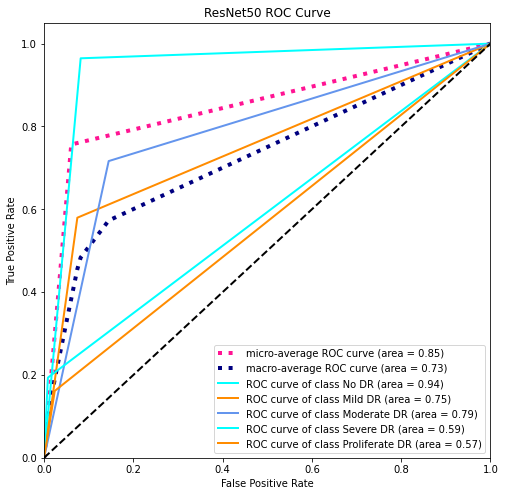

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

y_test = np.asarray(ytrue1)
y_score = np.asarray(ypred)
lw = 2
# First aggregate all false positive rates
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

classes = ["No DR", "Mild DR", "Moderate DR", "Severe DR", "Proliferate DR"]
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 ROC Curve")
plt.legend(loc="lower right")
plt.show()